In [45]:
import warnings
warnings.filterwarnings('ignore')

In [368]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pma

from tqdm import tqdm

In [47]:
# !pip install --upgrade "statsmodels>=0.14"

In [48]:
plt.style.use('ggplot')

In [49]:
cpih = pd.read_csv('CPIHOSSL.csv')
cpih.head()

,observation_date,CPIHOSSL
0,1967-01-01,30.5
1,1967-02-01,30.5
2,1967-03-01,30.5
3,1967-04-01,30.6
4,1967-05-01,30.7


In [50]:
cpih['CPIHOSSL'] = cpih['CPIHOSSL'].astype(float)

In [51]:
cpih['CPIHOSSL_delta'] = cpih['CPIHOSSL'].diff()

In [52]:
cpih['CPIHOSSL_log'] = np.log(cpih['CPIHOSSL'])
cpih['CPIHOSSL_logdelta'] = cpih['CPIHOSSL_log'].diff()

In [53]:
cpih.head()

,observation_date,CPIHOSSL,CPIHOSSL_delta,CPIHOSSL_log,CPIHOSSL_logdelta
0,1967-01-01,30.5,NaN,3.417727,NaN
1,1967-02-01,30.5,0.0,3.417727,0.000000
2,1967-03-01,30.5,0.0,3.417727,0.000000
3,1967-04-01,30.6,0.1,3.421000,0.003273
4,1967-05-01,30.7,0.1,3.424263,0.003263


In [54]:
cpih

,observation_date,CPIHOSSL,CPIHOSSL_delta,CPIHOSSL_log,CPIHOSSL_logdelta
0,1967-01-01,30.500,NaN,3.417727,NaN
1,1967-02-01,30.500,0.000,3.417727,0.000000
2,1967-03-01,30.500,0.000,3.417727,0.000000
3,1967-04-01,30.600,0.100,3.421000,0.003273
4,1967-05-01,30.700,0.100,3.424263,0.003263
...,...,...,...,...,...
699,2025-04-01,344.919,1.627,5.843310,0.004728
700,2025-05-01,345.867,0.948,5.846054,0.002745
701,2025-06-01,346.957,1.090,5.849201,0.003147
702,2025-07-01,347.713,0.756,5.851377,0.002177


In [55]:
cpih['observation_date'] = pd.to_datetime(cpih['observation_date'])

In [56]:
cpih_rec = cpih[cpih['observation_date'] >= pd.to_datetime('2020-01-01')]
cpih_realrec = cpih[cpih['observation_date'] >= pd.to_datetime('2024-01-01')]

Text(0, 0.5, 'CPI for Urban Consumers - Housing')

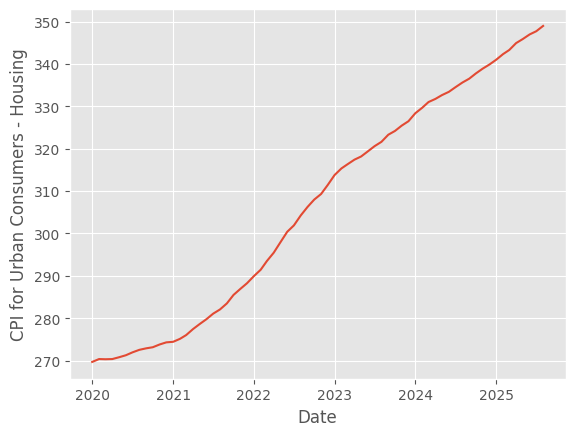

In [57]:
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSSL'])
plt.xlabel('Date')
plt.ylabel('CPI for Urban Consumers - Housing')

Text(0, 0.5, 'Monthly Change in CPIHOSSL')

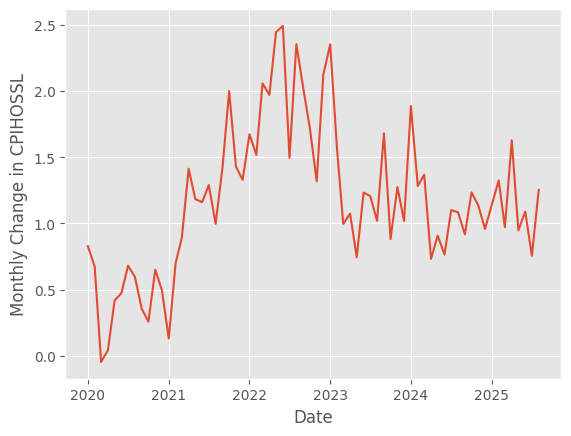

In [58]:
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSSL_delta'])
plt.xlabel('Date')
plt.ylabel('Monthly Change in CPIHOSSL')

In [192]:
adf_test = adfuller(cpih['CPIHOSSL_logdelta'][1:].values)
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.362305
p-value: 0.012313


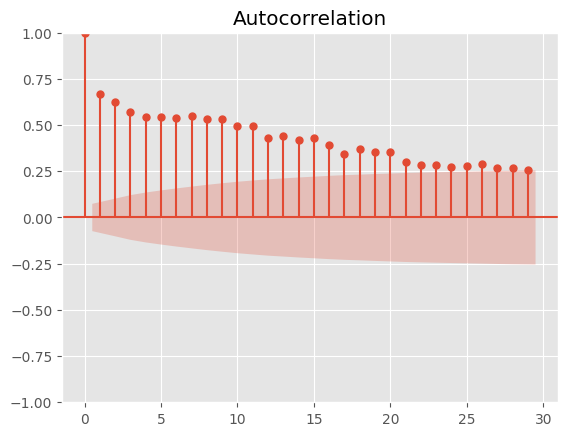

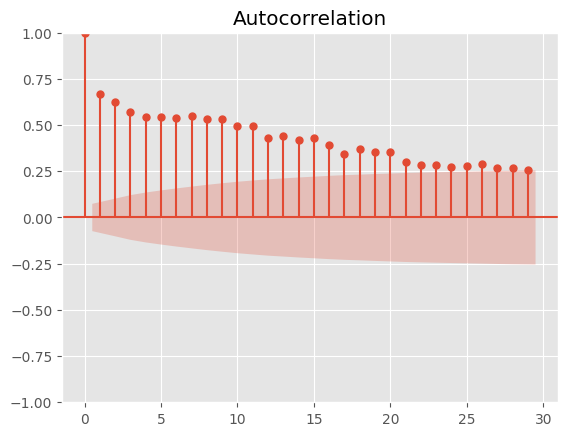

In [59]:
plot_acf(cpih['CPIHOSSL_logdelta'][1:])

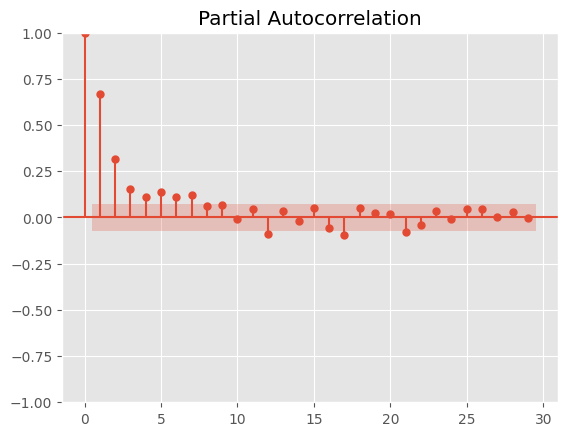

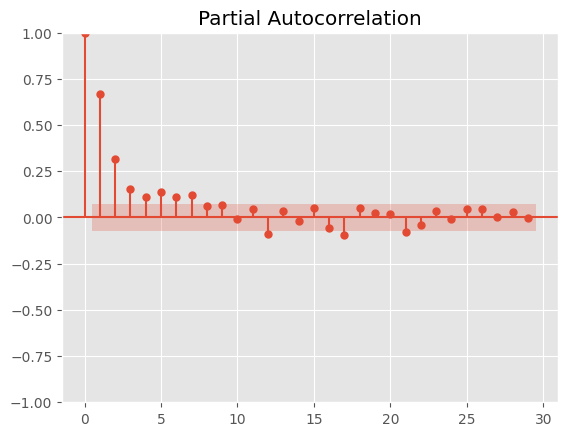

In [60]:
plot_pacf(cpih['CPIHOSSL_logdelta'][1:])

In [61]:
b = 15

In [62]:
end = cpih['CPIHOSSL_logdelta'][1:].values.shape[0] - b
end

688

In [97]:
armod_sm = AutoReg(cpih['CPIHOSSL_logdelta'][1:end].values, lags = 7).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  687
Model:                     AutoReg(7)   Log Likelihood                3231.836
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Sun, 14 Sep 2025   AIC                          -6445.672
Time:                        17:36:43   BIC                          -6404.973
Sample:                             7   HQIC                         -6429.918
                                  687                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.950      0.003       0.000       0.001
y.L1           0.3521      0.038      9.246      0.000       0.277       0.427
y.L2           0.1886      0.040      4.677      0.0

In [99]:
k, n_train = b + 1, cpih['CPIHOSSL_logdelta'][1:end].values.shape[0]
fcast = armod_sm.get_prediction(start = n_train, end = n_train + k - 1)
fcast_mean = fcast.predicted_mean
fcast_mean

array([0.00315348, 0.00338378, 0.00346203, 0.0037627 , 0.00356566,
       0.00353887, 0.00335787, 0.00341812, 0.00345436, 0.00348065,
       0.00351785, 0.00350046, 0.00349346, 0.0034754 , 0.00347908,
       0.00348499])

In [101]:
diffs_with_pred = np.append(cpih['CPIHOSSL_logdelta'][1:end].values, fcast_mean)
diffs_with_pred.shape

(703,)

In [103]:
pred_df = pd.DataFrame({'observation_date': cpih['observation_date'][1:], 'diffs': diffs_with_pred}).set_index(['observation_date'])
pred_df

,diffs
observation_date,
1967-02-01,0.000000
1967-03-01,0.000000
1967-04-01,0.003273
1967-05-01,0.003263
1967-06-01,0.000000
...,...
2025-04-01,0.003500
2025-05-01,0.003493
2025-06-01,0.003475


In [105]:
base = np.log(30.5)
pred_df['pred_logcpi'] = pred_df['diffs'].cumsum() + base

In [107]:
pred_df['diffs'][-10:]

observation_date
2024-11-01    0.003358
2024-12-01    0.003418
2025-01-01    0.003454
2025-02-01    0.003481
2025-03-01    0.003518
2025-04-01    0.003500
2025-05-01    0.003493
2025-06-01    0.003475
2025-07-01    0.003479
2025-08-01    0.003485
Name: diffs, dtype: float64

In [109]:
cpih[-10:]

,observation_date,CPIHOSSL,CPIHOSSL_delta,CPIHOSSL_log,CPIHOSSL_logdelta
694,2024-11-01,338.894,1.135,5.825687,0.003355
695,2024-12-01,339.853,0.959,5.828513,0.002826
696,2025-01-01,340.995,1.142,5.831868,0.003355
697,2025-02-01,342.320,1.325,5.835746,0.003878
698,2025-03-01,343.292,0.972,5.838581,0.002835
699,2025-04-01,344.919,1.627,5.843310,0.004728
700,2025-05-01,345.867,0.948,5.846054,0.002745
701,2025-06-01,346.957,1.090,5.849201,0.003147
702,2025-07-01,347.713,0.756,5.851377,0.002177
703,2025-08-01,348.967,1.254,5.854977,0.003600


In [111]:
pred_df = pred_df.reset_index()

In [113]:
pred_df['pred_cpi'] = np.exp(pred_df['pred_logcpi'])

In [115]:
pred_df['diffs_real'] = pred_df['pred_cpi'].diff().values

In [117]:
pred_df

,observation_date,diffs,pred_logcpi,pred_cpi,diffs_real
0,1967-02-01,0.000000,3.417727,30.500000,NaN
1,1967-03-01,0.000000,3.417727,30.500000,0.000000
2,1967-04-01,0.003273,3.421000,30.600000,0.100000
3,1967-05-01,0.003263,3.424263,30.700000,0.100000
4,1967-06-01,0.000000,3.424263,30.700000,0.000000
...,...,...,...,...,...
698,2025-04-01,0.003500,5.845965,345.836266,1.208469
699,2025-05-01,0.003493,5.849459,347.046545,1.210280
700,2025-06-01,0.003475,5.852934,348.254770,1.208225
701,2025-07-01,0.003479,5.856413,349.468487,1.213717


In [119]:
pred_df_rec = pred_df[pred_df['observation_date'] >= pd.to_datetime('2020-01-01')]

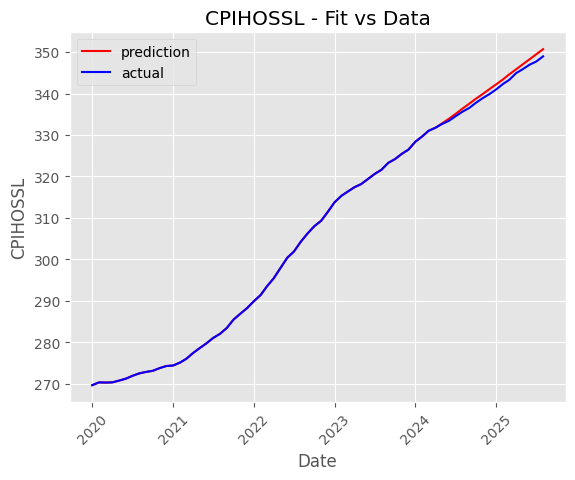

In [121]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['pred_cpi'], label='prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSSL'], label='actual', color='blue')
plt.xlabel('Date')
plt.ylabel('CPIHOSSL')
plt.title('CPIHOSSL - Fit vs Data')
plt.xticks(rotation=45)
plt.legend();

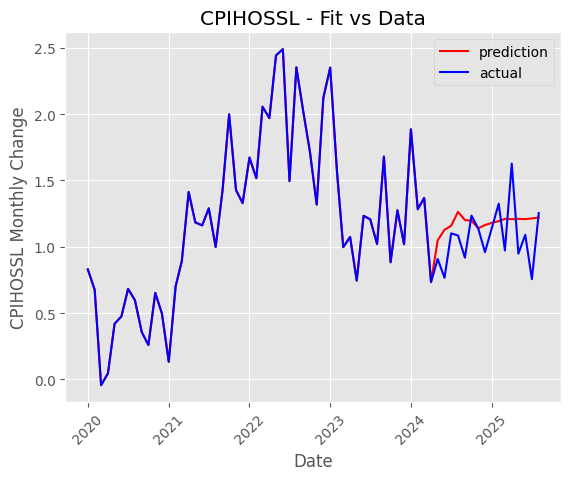

In [123]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['diffs_real'], label='prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSSL_delta'], label='actual', color='blue')
plt.xlabel('Date')
plt.ylabel('CPIHOSSL Monthly Change')
plt.title('CPIHOSSL - Fit vs Data')
plt.xticks(rotation=45)
plt.legend();

### Future Predictions (AR Model)

In [129]:
armod_sm = AutoReg(cpih['CPIHOSSL_logdelta'][1:].values, lags = 7).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  703
Model:                     AutoReg(7)   Log Likelihood                3315.032
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Sun, 14 Sep 2025   AIC                          -6612.065
Time:                        17:37:12   BIC                          -6571.157
Sample:                             7   HQIC                         -6596.247
                                  703                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.988      0.003       0.000       0.001
y.L1           0.3512      0.038      9.336      0.000       0.277       0.425
y.L2           0.1899      0.040      4.768      0.0

In [151]:
# Predictions for future
b = 20
k, n_train = b, cpih['CPIHOSSL_logdelta'][1:].values.shape[0]
fcast = armod_sm.get_prediction(start = n_train, end = n_train + k - 1)
fcast_mean = fcast.predicted_mean
fcast_mean

array([0.00333844, 0.00331838, 0.00345376, 0.00323076, 0.00326112,
       0.00319439, 0.00331872, 0.00332364, 0.00333553, 0.00335063,
       0.00333164, 0.00333718, 0.00333719, 0.00335359, 0.00336173,
       0.00336885, 0.00337488, 0.00337731, 0.00338182, 0.00338608])

In [204]:
fcast.conf_int()

array([[-0.00071176,  0.00738863],
       [-0.00097435,  0.00761111],
       [-0.00102254,  0.00793007],
       [-0.00134816,  0.00780968],
       [-0.00138066,  0.0079029 ],
       [-0.00152666,  0.00791545],
       [-0.00148852,  0.00812596],
       [-0.0016372 ,  0.00828449],
       [-0.00172476,  0.00839582],
       [-0.00179456,  0.00849583],
       [-0.00188204,  0.00854532],
       [-0.00193414,  0.00860849],
       [-0.00198962,  0.00866401],
       [-0.00202624,  0.00873341],
       [-0.00207138,  0.00879484],
       [-0.00211151,  0.0088492 ],
       [-0.00214813,  0.00889788],
       [-0.00218381,  0.00893843],
       [-0.00221371,  0.00897735],
       [-0.00224126,  0.00901341]])

In [153]:
start_date = '2025-09-01'
periods = b

dates_fut = pd.date_range(start=start_date, periods=periods, freq='MS')
dates_fut

DatetimeIndex(['2025-09-01', '2025-10-01', '2025-11-01', '2025-12-01',
               '2026-01-01', '2026-02-01', '2026-03-01', '2026-04-01',
               '2026-05-01', '2026-06-01', '2026-07-01', '2026-08-01',
               '2026-09-01', '2026-10-01', '2026-11-01', '2026-12-01',
               '2027-01-01', '2027-02-01', '2027-03-01', '2027-04-01'],
              dtype='datetime64[ns]', freq='MS')

In [214]:
confint = pd.DataFrame(
    {
        'observation_date': dates_fut,
        'lower_ci_log': fcast.conf_int()[:, 0],
        'upper_ci_log': fcast.conf_int()[:, 1]
    }
)
confint

,observation_date,lower_ci_log,upper_ci_log
0,2025-09-01,-0.000712,0.007389
1,2025-10-01,-0.000974,0.007611
2,2025-11-01,-0.001023,0.007930
3,2025-12-01,-0.001348,0.007810
4,2026-01-01,-0.001381,0.007903
5,2026-02-01,-0.001527,0.007915
6,2026-03-01,-0.001489,0.008126
7,2026-04-01,-0.001637,0.008284
8,2026-05-01,-0.001725,0.008396
9,2026-06-01,-0.001795,0.008496


In [216]:
# confint['lower_ci'] = np.exp(confint['lower_ci_log'])
# confint['upper_ci'] = np.exp(confint['upper_ci_log'])
# confint.head()

In [220]:
latest = cpih['CPIHOSSL_log'].values[-1]
latest

5.854977361857813

In [222]:
confint['pred_lower_ci_log'] = confint['lower_ci_log'].cumsum() + latest
confint['pred_upper_ci_log'] = confint['upper_ci_log'].cumsum() + latest
confint.head()

,observation_date,lower_ci_log,upper_ci_log,pred_lower_ci_log,pred_upper_ci_log
0,2025-09-01,-0.000712,0.007389,5.854266,5.862366
1,2025-10-01,-0.000974,0.007611,5.853291,5.869977
2,2025-11-01,-0.001023,0.007930,5.852269,5.877907
3,2025-12-01,-0.001348,0.007810,5.850921,5.885717
4,2026-01-01,-0.001381,0.007903,5.849540,5.893620


In [224]:
confint['pred_lower_ci'] = np.exp(confint['pred_lower_ci_log'])
confint['pred_upper_ci'] = np.exp(confint['pred_upper_ci_log'])
confint.head()

,observation_date,lower_ci_log,upper_ci_log,pred_lower_ci_log,pred_upper_ci_log,pred_lower_ci,pred_upper_ci
0,2025-09-01,-0.000712,0.007389,5.854266,5.862366,348.718708,351.554938
1,2025-10-01,-0.000974,0.007611,5.853291,5.869977,348.379099,354.240870
2,2025-11-01,-0.001023,0.007930,5.852269,5.877907,348.023049,357.061192
3,2025-12-01,-0.001348,0.007810,5.850921,5.885717,347.554174,359.860642
4,2026-01-01,-0.001381,0.007903,5.849540,5.893620,347.074651,362.715853


In [238]:
confint['diff_lower_ci'] = confint['pred_lower_ci'].diff().values
confint['diff_upper_ci'] = confint['pred_upper_ci'].diff().values
confint.head(7)

,observation_date,lower_ci_log,upper_ci_log,pred_lower_ci_log,pred_upper_ci_log,pred_lower_ci,pred_upper_ci,diff_lower_ci,diff_upper_ci
0,2025-09-01,-0.000712,0.007389,5.854266,5.862366,348.718708,351.554938,NaN,NaN
1,2025-10-01,-0.000974,0.007611,5.853291,5.869977,348.379099,354.240870,-0.339609,2.685931
2,2025-11-01,-0.001023,0.007930,5.852269,5.877907,348.023049,357.061192,-0.356050,2.820323
3,2025-12-01,-0.001348,0.007810,5.850921,5.885717,347.554174,359.860642,-0.468874,2.799450
4,2026-01-01,-0.001381,0.007903,5.849540,5.893620,347.074651,362.715853,-0.479524,2.855211
5,2026-02-01,-0.001527,0.007915,5.848013,5.901535,346.545189,365.598305,-0.529462,2.882452
6,2026-03-01,-0.001489,0.008126,5.846525,5.909661,346.029732,368.581244,-0.515456,2.982939


In [155]:
diffs_with_pred = np.append(cpih['CPIHOSSL_logdelta'][1:].values, fcast_mean)
diffs_with_pred.shape

(723,)

In [157]:
pred_df = pd.DataFrame({'observation_date': np.append(cpih['observation_date'][1:].values, dates_fut), 'diffs': diffs_with_pred}).set_index(['observation_date'])
pred_df

,diffs
observation_date,
1967-02-01,0.000000
1967-03-01,0.000000
1967-04-01,0.003273
1967-05-01,0.003263
1967-06-01,0.000000
...,...
2026-12-01,0.003369
2027-01-01,0.003375
2027-02-01,0.003377


In [159]:
base = np.log(30.5)
pred_df['pred_logcpi'] = pred_df['diffs'].cumsum() + base

In [161]:
pred_df = pred_df.reset_index()
pred_df['pred_cpi'] = np.exp(pred_df['pred_logcpi'])
pred_df['diffs_real'] = pred_df['pred_cpi'].diff().values

In [163]:
pred_df

,observation_date,diffs,pred_logcpi,pred_cpi,diffs_real
0,1967-02-01,0.000000,3.417727,30.500000,NaN
1,1967-03-01,0.000000,3.417727,30.500000,0.000000
2,1967-04-01,0.003273,3.421000,30.600000,0.100000
3,1967-05-01,0.003263,3.424263,30.700000,0.100000
4,1967-06-01,0.000000,3.424263,30.700000,0.000000
...,...,...,...,...,...
718,2026-12-01,0.003369,5.908193,368.040473,1.237785
719,2027-01-01,0.003375,5.911568,369.284664,1.244191
720,2027-02-01,0.003377,5.914945,370.533962,1.249298
721,2027-03-01,0.003382,5.918327,371.789162,1.255200


In [165]:
pred_df_rec = pred_df[pred_df['observation_date'] >= pd.to_datetime('2020-01-01')]

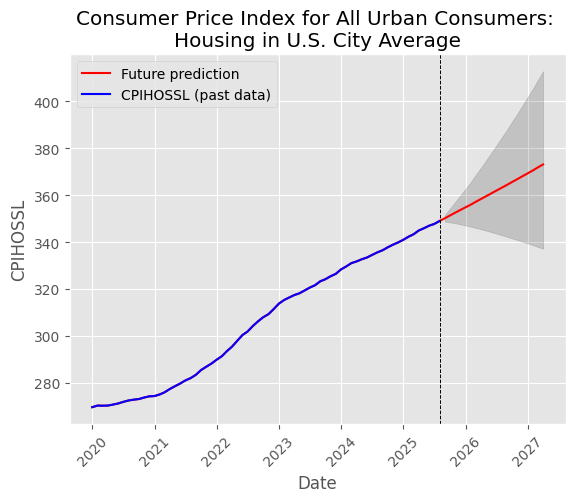

In [226]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['pred_cpi'], label='Future prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSSL'], label='CPIHOSSL (past data)', color='blue')
plt.fill_between(
    confint['observation_date'],
    confint['pred_lower_ci'],
    confint['pred_upper_ci'],
    color='k', alpha=0.15
)
plt.axvline(x=pd.to_datetime('2025-08-01'), color='black', linestyle='--', linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('CPIHOSSL')
plt.title('Consumer Price Index for All Urban Consumers: \nHousing in U.S. City Average')
plt.xticks(rotation=45)
plt.legend();

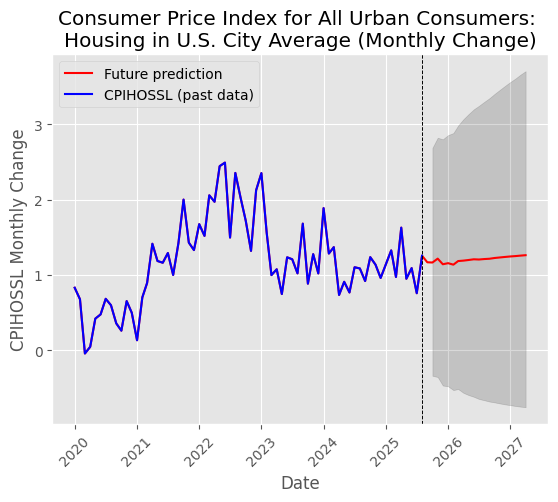

In [244]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['diffs_real'], label='Future prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSSL_delta'], label='CPIHOSSL (past data)', color='blue')
plt.fill_between(
    confint['observation_date'],
    confint['diff_lower_ci'],
    confint['diff_upper_ci'],
    color='k', alpha=0.15
)
plt.axvline(x=pd.to_datetime('2025-08-01'), color='black', linestyle='--', linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('CPIHOSSL Monthly Change')
plt.title('Consumer Price Index for All Urban Consumers: \nHousing in U.S. City Average (Monthly Change)')
plt.xticks(rotation=45)
plt.legend();

### Fitting ARIMA Model

In [412]:
model = pma.auto_arima(cpih['CPIHOSSL_log'], seasonal=False, stepwise=True, suppress_warnings=True,
                      start_p=2, start_d=1, start_q=13, max_q=20)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  704
Model:              SARIMAX(1, 2, 12)   Log Likelihood                3345.747
Date:                Sun, 14 Sep 2025   AIC                          -6663.494
Time:                        19:51:29   BIC                          -6599.739
Sample:                             0   HQIC                         -6638.852
                                - 704                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3849      0.236     -1.634      0.102      -0.847       0.077
ma.L1         -0.2505      0.233     -1.075      0.282      -0.707       0.206
ma.L2         -0.2793      0.160     -1.747      0.081      -0.593       0.034
ma.L3         -0.0818      0.029     -2.845      0.004      -0.138      -0.025
ma.L4         -0.1085      0.036     -3.039      0.002      -0.179      -0.039
ma.L5         -0.0020      0.042     -0.048      0.962      -0.084       0.080
ma.L6          0.0238      0.032      0.750      0.453      -0.038       0.086
ma.L7          0.0588      0.033      1.789      0.074      -0.006       0.123
ma.L8          0.0076      0.034      0.224      0.823      -0.059       0.074
ma.L9          0.0377      0.032      1.180      0.238      -0.025       0.100
ma.L10        -0.0233      0.037     -0.623      0.533      -0.096       0.050
ma.L11         0.0367      0.038      0.958      0.338      -0.038       0.112
ma.L12        -0.1046      0.032     -3.267      0.001      -0.167      -0.042
sigma2      4.221e-06    9.3e-08     45.412      0.000    4.04e-06     4.4e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             10004.78
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                            -1.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [414]:
# ARIMA(2, 1, 13) model used by Biden administration's CPI blog
# https://bidenwhitehouse.archives.gov/cea/written-materials/2024/12/11/december-cpi-blog-updating-our-housing-model/
# Not sure about applicability for CPIHOSSL though

model = ARIMA(cpih['CPIHOSSL_log'], order=(1, 2, 12)).fit()
# model = pma.auto_arima(cpih['CPIHOSSL_log'], seasonal=False, stepwise=True, suppress_warnings=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           CPIHOSSL_log   No. Observations:                  704
Model:                ARIMA(1, 2, 12)   Log Likelihood                3345.747
Date:                Sun, 14 Sep 2025   AIC                          -6663.494
Time:                        19:51:37   BIC                          -6599.739
Sample:                             0   HQIC                         -6638.852
                                - 704                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3849      0.236     -1.634      0.102      -0.847       0.077
ma.L1         -0.2505      0.233     -1.075      0.282      -0.707       0.206
ma.L2         -0.2793      0.160     -1.747      0.081      -0.593       0.034
ma.L3         -0.0818      0.029     -2.845      0.004      -0.138      -0.025
ma.L4         -0.1085      0.036     -3.039      0.002      -0.179      -0.039
ma.L5         -0.0020      0.042     -0.048      0.962      -0.084       0.080
ma.L6          0.0238      0.032      0.750      0.453      -0.038       0.086
ma.L7          0.0588      0.033      1.789      0.074      -0.006       0.123
ma.L8          0.0076      0.034      0.224      0.823      -0.059       0.074
ma.L9          0.0377      0.032      1.180      0.238      -0.025       0.100
ma.L10        -0.0233      0.037     -0.623      0.533      -0.096       0.050
ma.L11         0.0367      0.038      0.958      0.338      -0.038       0.112
ma.L12        -0.1046      0.032     -3.267      0.001      -0.167      -0.042
sigma2      4.221e-06    9.3e-08     45.412      0.000    4.04e-06     4.4e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             10004.78
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                            -1.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [416]:
b = 24
forecast = model.get_forecast(steps=b)
fcast = forecast
fcast_mean = forecast.predicted_mean
fcast_mean

704    5.858333
705    5.861741
706    5.865207
707    5.868587
708    5.871976
709    5.875163
710    5.878570
711    5.881689
712    5.885059
713    5.888308
714    5.891739
715    5.895027
716    5.898369
717    5.901691
718    5.905021
719    5.908347
720    5.911675
721    5.915002
722    5.918330
723    5.921657
724    5.924985
725    5.928312
726    5.931640
727    5.934967
Name: predicted_mean, dtype: float64

In [418]:
forecast.conf_int()

,lower CPIHOSSL_log,upper CPIHOSSL_log
704,5.854306,5.862360
705,5.854928,5.868555
706,5.855563,5.874850
707,5.856135,5.881039
708,5.856843,5.887109
709,5.857327,5.893000
710,5.857957,5.899183
711,5.858114,5.905265
712,5.858376,5.911742
713,5.858303,5.918314


In [420]:
data_with_pred = np.append(cpih['CPIHOSSL_log'].values, fcast_mean)
data_with_pred.shape

(728,)

In [422]:
start_date = '2025-09-01'
periods = b

dates_fut = pd.date_range(start=start_date, periods=periods, freq='MS')
dates_fut

DatetimeIndex(['2025-09-01', '2025-10-01', '2025-11-01', '2025-12-01',
               '2026-01-01', '2026-02-01', '2026-03-01', '2026-04-01',
               '2026-05-01', '2026-06-01', '2026-07-01', '2026-08-01',
               '2026-09-01', '2026-10-01', '2026-11-01', '2026-12-01',
               '2027-01-01', '2027-02-01', '2027-03-01', '2027-04-01',
               '2027-05-01', '2027-06-01', '2027-07-01', '2027-08-01'],
              dtype='datetime64[ns]', freq='MS')

In [424]:
arima_pred = pd.DataFrame(
    {
        'observation_date': dates_fut,
        'fcast_CPI_log': fcast_mean
    }
)
arima_pred

,observation_date,fcast_CPI_log
704,2025-09-01,5.858333
705,2025-10-01,5.861741
706,2025-11-01,5.865207
707,2025-12-01,5.868587
708,2026-01-01,5.871976
709,2026-02-01,5.875163
710,2026-03-01,5.878570
711,2026-04-01,5.881689
712,2026-05-01,5.885059
713,2026-06-01,5.888308


In [426]:
arima_pred['fcast_CPI'] = np.exp(arima_pred['fcast_CPI_log'])
arima_pred.head()

,observation_date,fcast_CPI_log,fcast_CPI
704,2025-09-01,5.858333,350.139928
705,2025-10-01,5.861741,351.335332
706,2025-11-01,5.865207,352.555033
707,2025-12-01,5.868587,353.748682
708,2026-01-01,5.871976,354.949636


In [428]:
arima_pred['lower_ci_log'] = fcast.conf_int().iloc[:, 0]
arima_pred['upper_ci_log'] = fcast.conf_int().iloc[:, 1]
arima_pred.head(7)

,observation_date,fcast_CPI_log,fcast_CPI,lower_ci_log,upper_ci_log
704,2025-09-01,5.858333,350.139928,5.854306,5.862360
705,2025-10-01,5.861741,351.335332,5.854928,5.868555
706,2025-11-01,5.865207,352.555033,5.855563,5.874850
707,2025-12-01,5.868587,353.748682,5.856135,5.881039
708,2026-01-01,5.871976,354.949636,5.856843,5.887109
709,2026-02-01,5.875163,356.082853,5.857327,5.893000
710,2026-03-01,5.878570,357.297918,5.857957,5.899183


In [430]:
arima_pred['lower_ci'] = np.exp(arima_pred['lower_ci_log'])
arima_pred['upper_ci'] = np.exp(arima_pred['upper_ci_log'])
arima_pred

,observation_date,fcast_CPI_log,fcast_CPI,lower_ci_log,upper_ci_log,lower_ci,upper_ci
704,2025-09-01,5.858333,350.139928,5.854306,5.862360,348.732692,351.552843
705,2025-10-01,5.861741,351.335332,5.854928,5.868555,348.949677,353.737297
706,2025-11-01,5.865207,352.555033,5.855563,5.874850,349.171502,355.971352
707,2025-12-01,5.868587,353.748682,5.856135,5.881039,349.371092,358.181123
708,2026-01-01,5.871976,354.949636,5.856843,5.887109,349.618613,360.361948
709,2026-02-01,5.875163,356.082853,5.857327,5.893000,349.787880,362.491114
710,2026-03-01,5.878570,357.297918,5.857957,5.899183,350.008331,364.739323
711,2026-04-01,5.881689,358.414197,5.858114,5.905265,350.063324,366.964282
712,2026-05-01,5.885059,359.623992,5.858376,5.911742,350.155188,369.348849
713,2026-06-01,5.888308,360.794423,5.858303,5.918314,350.129405,371.784300


In [432]:
arima_pred['fcast_diff'] = arima_pred['fcast_CPI'].diff().values
arima_pred['diff_lower_ci'] = arima_pred['lower_ci'].diff().values
arima_pred['diff_upper_ci'] = arima_pred['upper_ci'].diff().values
arima_pred.head(7)

,observation_date,fcast_CPI_log,fcast_CPI,lower_ci_log,upper_ci_log,lower_ci,upper_ci,fcast_diff,diff_lower_ci,diff_upper_ci
704,2025-09-01,5.858333,350.139928,5.854306,5.862360,348.732692,351.552843,NaN,NaN,NaN
705,2025-10-01,5.861741,351.335332,5.854928,5.868555,348.949677,353.737297,1.195404,0.216985,2.184454
706,2025-11-01,5.865207,352.555033,5.855563,5.874850,349.171502,355.971352,1.219701,0.221825,2.234054
707,2025-12-01,5.868587,353.748682,5.856135,5.881039,349.371092,358.181123,1.193649,0.199590,2.209771
708,2026-01-01,5.871976,354.949636,5.856843,5.887109,349.618613,360.361948,1.200954,0.247521,2.180825
709,2026-02-01,5.875163,356.082853,5.857327,5.893000,349.787880,362.491114,1.133216,0.169267,2.129166
710,2026-03-01,5.878570,357.297918,5.857957,5.899183,350.008331,364.739323,1.215065,0.220452,2.248209


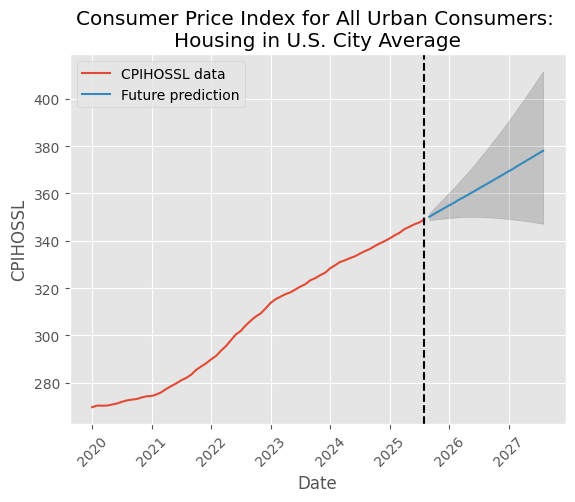

In [434]:
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSSL'], label='CPIHOSSL data')
plt.plot(arima_pred['observation_date'], arima_pred['fcast_CPI'], label='Future prediction')
plt.fill_between(
    arima_pred['observation_date'],
    arima_pred['lower_ci'],
    arima_pred['upper_ci'],
    color='k', alpha=0.15
)
plt.axvline(x = pd.to_datetime('2025-08-01'), color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('CPIHOSSL')
plt.title('Consumer Price Index for All Urban Consumers: \nHousing in U.S. City Average')
plt.xticks(rotation=45)
plt.legend();

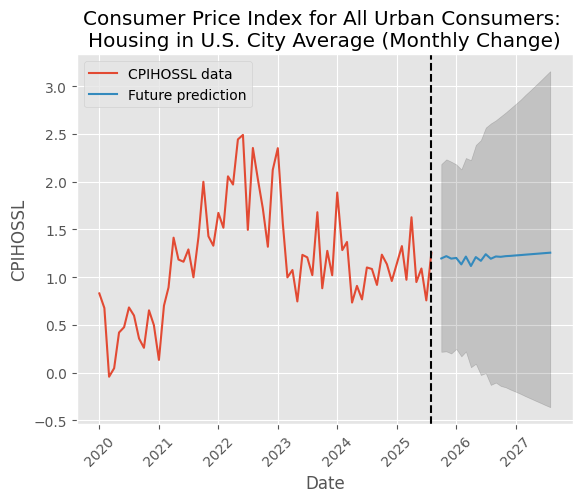

In [436]:
plt.plot(cpih_rec['observation_date'], cpih_rec['CPIHOSSL_delta'], label='CPIHOSSL data')
plt.plot(arima_pred['observation_date'], arima_pred['fcast_diff'], label='Future prediction')
plt.fill_between(
    arima_pred['observation_date'],
    arima_pred['diff_lower_ci'],
    arima_pred['diff_upper_ci'],
    color='k', alpha=0.15
)
plt.axvline(x = pd.to_datetime('2025-08-01'), color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('CPIHOSSL')
plt.title('Consumer Price Index for All Urban Consumers: \nHousing in U.S. City Average (Monthly Change)')
plt.xticks(rotation=45)
plt.legend();